In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


Reference: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

Calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

Supported image formats: jpeg, png, bmp, gif. Animated gifs are truncated to the first frame.

directory:	Directory where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class. Otherwise, the directory structure is ignored.

seed:	Optional random seed for shuffling and transformations.

shuffle:	Whether to shuffle the data. Default: True. If set to False, sorts the data in alphanumeric order.

image_size:	Size to resize images to after they are read from disk. Defaults to (256, 256). Since the pipeline processes batches of images that must all have the same size, this must be provided.

batch_size:	Size of the batches of data. Default: 32.

In [4]:
class_names=dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch)

(32, 256, 256, 3)
tf.Tensor([1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0], shape=(32,), dtype=int32)


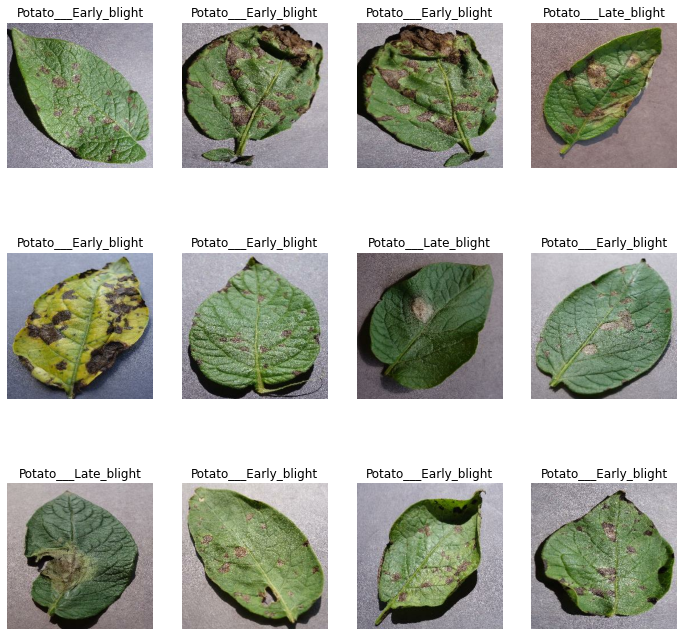

In [6]:
plt.figure(figsize=(12,12))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint'))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def split_train_test(dataset,train_size,test_size,eval_size,shuffle,shuffle_size):
    dataset_size=len(dataset)
    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_size*dataset_size)
    eval_size=int(eval_size*dataset_size)
    
    train_dataset=dataset.take(train_size)
    eval_dataset=dataset.skip(train_size).take(eval_size)
    test_dataset=dataset.skip(train_size).skip(eval_size)
    
    return train_dataset,test_dataset,eval_dataset
    

In [8]:
train_dataset,test_dataset,eval_dataset=split_train_test(dataset,train_size=0.8,test_size=0.1,eval_size=0.1,shuffle=True,shuffle_size=10000)

In [9]:
print("Length of Training data:",len(train_dataset))
print("Length of Testing data:",len(test_dataset))
print("Length of evaluating data:",len(eval_dataset))

Length of Training data: 54
Length of Testing data: 8
Length of evaluating data: 6


In [10]:
train_dataset=train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset=test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
eval_dataset=eval_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [11]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

Data Augmentation : Improving accuracy when we have less data

Randomly flip each image horizontally and vertically.

Randomly rotate each image.factor: A positive values means rotating counter clock-wise, while a negative value means clock-wise.
factor=0.2 results in an output rotating by a random amount in the range [-20% * 2pi, 20% * 2pi].

In [12]:
data_agumentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
train_dataset=train_dataset.map(lambda x,y:(data_agumentation(x,training=True),y)).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
len(train_dataset)

54

In [14]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [16]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [17]:
history=model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=eval_dataset,
    verbose=1,
    epochs=50
)

Epoch 1/50
54/54 [==============================] - 9s 164ms/step - loss: 0.8841 - accuracy: 0.5000 - val_loss: 0.7342 - val_accuracy: 0.6667
Epoch 2/50
54/54 [==============================] - 6s 117ms/step - loss: 0.6259 - accuracy: 0.7130 - val_loss: 0.4692 - val_accuracy: 0.7656
Epoch 3/50
54/54 [==============================] - 6s 118ms/step - loss: 0.3661 - accuracy: 0.8403 - val_loss: 0.2663 - val_accuracy: 0.8958
Epoch 4/50
54/54 [==============================] - 6s 119ms/step - loss: 0.2733 - accuracy: 0.8866 - val_loss: 0.2858 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 7s 122ms/step - loss: 0.2270 - accuracy: 0.9080 - val_loss: 0.2585 - val_accuracy: 0.8802
Epoch 6/50
54/54 [==============================] - 7s 127ms/step - loss: 0.1952 - accuracy: 0.9190 - val_loss: 0.2943 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 6s 118ms/step - loss: 0.2198 - accuracy: 0.9161 - val_loss: 0.1931 - val_accuracy: 0.9271
Epoch 

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

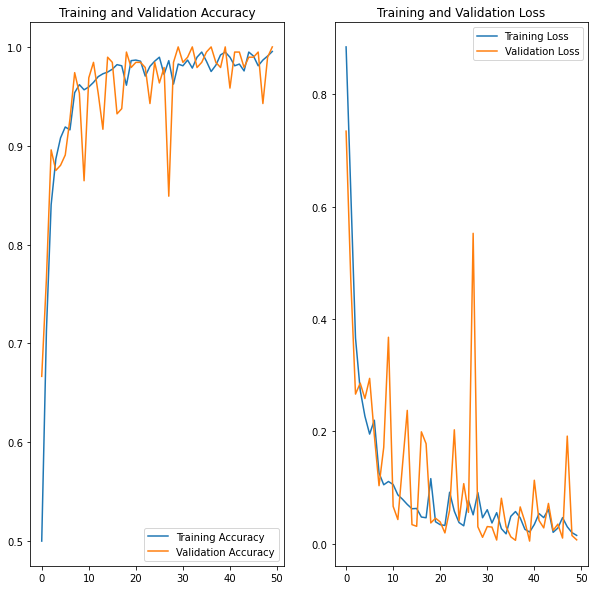

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

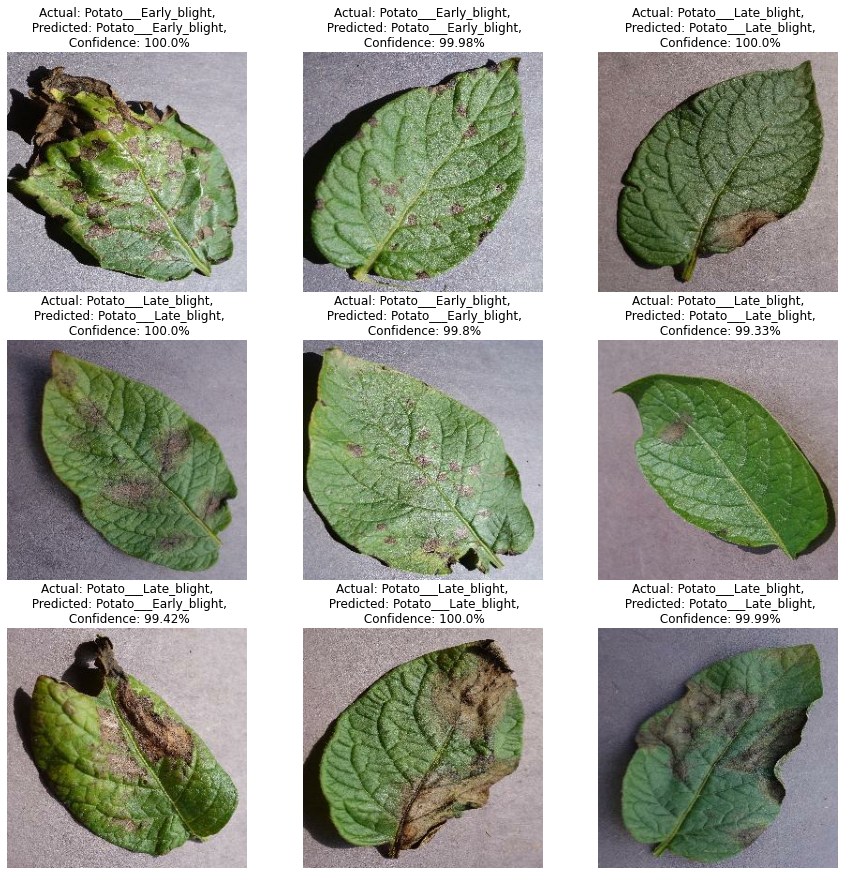

In [21]:
plt.figure(figsize=(15,15))
for images,labels in test_dataset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(model,images[i])
        actual_class=class_names[labels[i]]
        plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%')
        plt.axis('off')

In [23]:
import os
model_version=max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/1\assets


In [24]:
model.save("../potatoes.h5")